# Classifying Risks Leveraging Poisson Regression Model

- The frequency of claim is the target variable here.
- Minimal risk rating factor that can be leveraged to classify risks into frequency bands will be a good outcome to nail down
- Make the model an inference service that can bedeployed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import GeneralizedPoisson
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

## But First, Shall We Prepare the Dataset 

- Claims data includes yearly totals and breakdowns by claim type.
- Aggregate the claims data to obtain the claims frequency unique to each ID and year
- Merge result with rating factors on (ID, year).
- Assign a frequency of 0 to policies with no recorded claims.

In [3]:
rating_factors = pd.read_csv('../data/input/exp/Motor vehicle insurance data.csv', delimiter=";")
claims =  pd.read_csv('../data/input/exp/sample type claim.csv', delimiter=';')

In [4]:
claims_frequency  = (
    claims
    .groupby(['ID', 'Cost_claims_year'])
    .agg({
        'Cost_claims_by_type': 'count'})
    .rename(columns={'Cost_claims_by_type': 'claims_frequency'})
    .reset_index()
)

In [5]:
dataset = (
    pd.merge(
        left=rating_factors,
        right=claims_frequency,
        how='left',
        on=['ID', 'Cost_claims_year']
    )
)
dataset

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,claims_frequency
0,1,05/11/2015,05/11/2015,05/11/2016,15/04/1956,20/03/1976,0,4,1,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
1,1,05/11/2015,05/11/2016,05/11/2017,15/04/1956,20/03/1976,0,4,1,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
2,1,05/11/2015,05/11/2017,05/11/2018,15/04/1956,20/03/1976,0,4,2,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
3,1,05/11/2015,05/11/2018,05/11/2019,15/04/1956,20/03/1976,0,4,2,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
4,2,26/09/2017,26/09/2017,26/09/2018,15/04/1956,20/03/1976,0,4,2,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,53498,30/07/2018,30/07/2018,30/07/2019,25/07/1981,14/02/2007,0,1,1,1,...,0,2000,110,1997,24320.00,5,D,4.740,1480,NaN
105551,53499,16/08/2018,16/08/2018,16/08/2019,08/12/1976,29/11/2017,0,1,1,1,...,0,2013,129,1998,30861.97,5,P,4.650,1440,NaN
105552,53500,21/11/2018,21/11/2018,21/11/2019,01/04/1974,05/10/2011,0,1,1,1,...,0,1999,55,999,7800.00,5,P,3.495,830,NaN
105553,53501,21/11/2018,21/11/2018,21/11/2019,15/09/1946,02/02/1982,0,1,1,1,...,0,2004,90,1753,16610.00,5,D,4.555,1399,NaN


## Claims rate per unit exposure
- The data is structured such that each record is policy that runs for a year, as such let's calculate the claims rate per unit exposure (policy length)
- Creating matrix a using - Age, driving lenght, insurable object type (e.g van, motorcycle etc.)
    - Age banded into 3 levels of 0-35, 36-70, >70 as 0,1,2
    - Driving length banded into 2 levels of less than 5 years of experience and greater than 5 years experience as 0,1
    - Type risk has levels 1,2,3,4 representing motorbikes, van, passengers and agricultural vehicles respectively

In [6]:
rating_factors_a = (
    dataset
    .copy()[['Date_driving_licence','Date_birth','Type_risk', 'claims_frequency','Cost_claims_year',
             "Date_last_renewal", "Date_next_renewal","Seniority", "Payment", "Policies_in_force",
             "Second_driver", "R_Claims_history", "Power", "Value_vehicle", "N_claims_year","N_claims_history",
             "Lapse", "Distribution_channel"]]
             
    .fillna({'Date_driving_licence': pd.NaT,  'claims_frequency': 0})
    .assign(age_band=lambda x: pd.cut((pd.Timestamp.now() - pd.to_datetime(x['Date_birth'], dayfirst=True)).dt.days // 365, 
                                 bins=[0, 35, 70, float('inf')], 
                                 labels=[0, 1, 2], 
                                 include_lowest=True).astype(int))
    .assign(driving_length=lambda x:((pd.Timestamp.now() - pd.to_datetime(x['Date_driving_licence'], dayfirst=True)).dt.days // 365 >= 5).astype(int))
    .drop(columns=['Date_driving_licence', 'Date_birth'], axis=1)
    .assign(policy_length=lambda x: (pd.to_datetime(x['Date_next_renewal'], dayfirst=True) - pd.to_datetime(x["Date_last_renewal"], dayfirst=True)).dt.days)
)
rating_factors_a

,Type_risk,claims_frequency,Cost_claims_year,Date_last_renewal,Date_next_renewal,Seniority,Payment,Policies_in_force,Second_driver,R_Claims_history,Power,Value_vehicle,N_claims_year,N_claims_history,Lapse,Distribution_channel,age_band,driving_length,policy_length
0,1,0.0,0.0,05/11/2015,05/11/2016,4,0,1,0,0.0,80,7068.00,0,0,0,0,1,1,366
1,1,0.0,0.0,05/11/2016,05/11/2017,4,0,1,0,0.0,80,7068.00,0,0,0,0,1,1,365
2,1,0.0,0.0,05/11/2017,05/11/2018,4,0,2,0,0.0,80,7068.00,0,0,0,0,1,1,365
3,1,0.0,0.0,05/11/2018,05/11/2019,4,0,2,0,0.0,80,7068.00,0,0,0,0,1,1,365
4,1,0.0,0.0,26/09/2017,26/09/2018,4,1,2,0,0.0,80,7068.00,0,0,0,0,1,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,3,0.0,0.0,30/07/2018,30/07/2019,1,0,1,0,0.0,110,24320.00,0,0,0,0,1,1,365
105551,3,0.0,0.0,16/08/2018,16/08/2019,1,0,1,0,0.0,129,30861.97,0,0,0,0,1,1,365
105552,3,0.0,0.0,21/11/2018,21/11/2019,1,1,1,0,0.0,55,7800.00,0,0,0,0,1,1,365
105553,2,0.0,0.0,21/11/2018,21/11/2019,1,0,1,0,0.0,90,16610.00,0,0,0,0,2,1,365


In [7]:
rating_factors_matrix = (
    rating_factors_a
    .groupby(['age_band', 'driving_length', 'Type_risk'])
    .agg({'claims_frequency':'sum', 'Cost_claims_year':'sum'})
    .assign(claims_rate_per_unit_exposure=lambda x:(x['claims_frequency']/x['Cost_claims_year']))
    .reset_index()
    .fillna({'claims_rate_per_unit_exposure':0})
)
rating_factors_matrix

,age_band,driving_length,Type_risk,claims_frequency,Cost_claims_year,claims_rate_per_unit_exposure
0,0,1,1,27.0,51431.88,0.000525
1,0,1,2,24.0,49850.71,0.000481
2,0,1,3,493.0,1419727.91,0.000347
3,0,1,4,0.0,0.00,0.000000
4,1,1,1,209.0,224939.07,0.000929
5,1,1,2,820.0,1917103.39,0.000428
6,1,1,3,5113.0,11106978.68,0.000460
7,1,1,4,0.0,192.67,0.000000
8,2,1,1,16.0,32685.29,0.000490
9,2,1,2,143.0,230799.22,0.000620


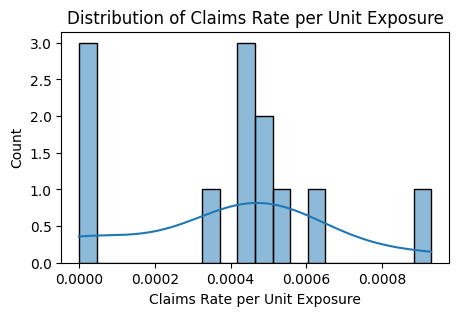

In [8]:
plt.figure(figsize=(5, 3))
sns.histplot(data=rating_factors_matrix, x='claims_rate_per_unit_exposure', bins=20, kde=True)
plt.title('Distribution of Claims Rate per Unit Exposure')
plt.xlabel('Claims Rate per Unit Exposure')
plt.ylabel('Count')
plt.show()


## Poisson Model - Shall we fit one?

In [9]:
train_dev, test = train_test_split(rating_factors_a, test_size=0.05, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.1, random_state=42)

print(f"Train set size: {len(train)}")
print(f"Dev set size: {len(dev)}")
print(f"Test set size: {len(test)}")
print(f"Total: {len(train) + len(dev) + len(test)}")

Train set size: 90249
Dev set size: 10028
Test set size: 5278
Total: 105555


In [10]:
X = train_dev[['Type_risk', 'age_band', 'policy_length', 'Seniority', "Second_driver",
               "R_Claims_history", "N_claims_year", "N_claims_history", ]]
y = train_dev[['claims_frequency']]

In [11]:
general_model =  GeneralizedPoisson(endog = y , exog = X, p=2).fit(method='nm')
print(general_model.summary())

                    GeneralizedPoisson Regression Results                     
Dep. Variable:       claims_frequency   No. Observations:               100277
Model:             GeneralizedPoisson   Df Residuals:                   100269
Method:                           MLE   Df Model:                            7
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:                  0.7234
Time:                        21:06:04   Log-Likelihood:                -25611.
converged:                      False   LL-Null:                       -92591.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Type_risk            0.2468      0.028      8.862      0.000       0.192       0.301
age_band            -0.1560      0.037     -4.192      0.000      -0.229      -0.083
policy_length       -0.0100 

In [16]:
def plot_discrete_poisson_diagnostics(model_result, figsize=(15, 12)):
    """
    Create comprehensive diagnostic plots for discrete Poisson regression
    Works with statsmodels.discrete.discrete_model.GeneralizedPoisson

    Parameters:
    -----------
    model_result : statsmodels discrete model results object
        Fitted discrete Poisson model results
    figsize : tuple
        Figure size for the plots
    """

    # Extract key components for discrete models
    fitted_values = np.array(model_result.fittedvalues)
    observed_values = np.array(model_result.model.endog)

    # Calculate residuals manually for discrete models
    response_residuals = observed_values - fitted_values

    # Pearson residuals for Poisson: (observed - fitted) / sqrt(fitted)
    pearson_residuals = response_residuals / np.sqrt(fitted_values)

    # Deviance residuals for Poisson
    # sign(y-μ) * sqrt(2 * [y*log(y/μ) - (y-μ)])
    deviance_residuals = np.zeros_like(observed_values)
    for i in range(len(observed_values)):
        y, mu = observed_values[i], fitted_values[i]
        if y > 0:
            dev_component = 2 * (y * np.log(y / mu) - (y - mu))
        else:
            dev_component = 2 * mu
        deviance_residuals[i] = np.sign(y - mu) * np.sqrt(dev_component)

    # Standardized residuals (approximate for discrete models)
    # For discrete models, we use leverage from the working weights
    try:
        # Try to get influence measures
        influence = model_result.get_influence()
        leverage = influence.hat_matrix_diag
        standardized_residuals = pearson_residuals / np.sqrt(1 - leverage)
    except:
        # If influence measures not available, use simpler standardization
        standardized_residuals = pearson_residuals / np.std(pearson_residuals)
        leverage = np.ones(len(pearson_residuals)) * (len(model_result.params) / len(pearson_residuals))

    # Create subplot layout
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle('Discrete Poisson Regression Diagnostics', fontsize=16, y=0.98)

    # 1. Residuals vs Fitted
    axes[0, 0].scatter(fitted_values, pearson_residuals, alpha=0.6, s=30)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.8)

    # Add lowess smooth line
    try:
        from statsmodels.nonparametric.smoothers_lowess import lowess
        if len(fitted_values) > 10:  # Only if enough points
            smoothed = lowess(pearson_residuals, fitted_values, frac=0.3)
            axes[0, 0].plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2)
    except:
        pass

    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Pearson Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Q-Q Plot of Pearson residuals
    # The following line causes the Q-Q plot to be drawn twice in Jupyter:
    # stats.probplot(pearson_residuals, dist="norm", plot=axes[0, 1])
    # This is because stats.probplot draws directly to the axes and also returns a tuple.
    # In Jupyter, if the function call is the last line in a cell or block, the returned value is also displayed,
    # which causes the plot to be rendered again.
    # To avoid double plotting, assign the result to a variable and do not return or display it.
    _ = stats.probplot(pearson_residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q Plot\n(Pearson Residuals)')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Scale-Location Plot
    sqrt_abs_std_resid = np.sqrt(np.abs(standardized_residuals))
    axes[0, 2].scatter(fitted_values, sqrt_abs_std_resid, alpha=0.6, s=30)

    try:
        if len(fitted_values) > 10:
            smoothed_scale = lowess(sqrt_abs_std_resid, fitted_values, frac=0.3)
            axes[0, 2].plot(smoothed_scale[:, 0], smoothed_scale[:, 1], color='red', linewidth=2)
    except:
        pass

    axes[0, 2].set_xlabel('Fitted Values')
    axes[0, 2].set_ylabel('√|Standardized Residuals|')
    axes[0, 2].set_title('Scale-Location Plot')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Response vs Fitted (for count data)
    axes[1, 0].scatter(fitted_values, observed_values, alpha=0.6, s=30)

    # Add perfect prediction line
    min_val = min(fitted_values.min(), observed_values.min())
    max_val = max(fitted_values.max(), observed_values.max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect fit')

    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Observed Values')
    axes[1, 0].set_title('Observed vs Fitted')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Deviance Residuals vs Index
    obs_index = np.arange(len(deviance_residuals))
    axes[1, 1].scatter(obs_index, deviance_residuals, alpha=0.6, s=30)
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
    axes[1, 1].set_xlabel('Observation Index')
    axes[1, 1].set_ylabel('Deviance Residuals')
    axes[1, 1].set_title('Deviance Residuals vs Index')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Histogram of Pearson Residuals
    axes[1, 2].hist(pearson_residuals, bins=min(20, len(pearson_residuals)//5),
                    density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Overlay normal distribution
    x_norm = np.linspace(pearson_residuals.min(), pearson_residuals.max(), 100)
    axes[1, 2].plot(x_norm, stats.norm.pdf(x_norm, pearson_residuals.mean(), pearson_residuals.std()),
                    'r-', linewidth=2, label='Normal')
    axes[1, 2].set_xlabel('Pearson Residuals')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].set_title('Histogram of Pearson Residuals')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

def discrete_poisson_summary(model_result):
    """
    Print diagnostic summary statistics for discrete Poisson models
    """
    print("=== DISCRETE POISSON REGRESSION DIAGNOSTICS ===\n")

    # Basic model info
    print(f"Model: {model_result.model.__class__.__name__}")
    print(f"Number of observations: {model_result.nobs}")
    print(f"Number of parameters: {len(model_result.params)}")
    print(f"Log-likelihood: {model_result.llf:.4f}")
    print(f"AIC: {model_result.aic:.4f}")
    print(f"BIC: {model_result.bic:.4f}")

    # Get basic residual info
    fitted_values = np.array(model_result.fittedvalues)
    observed_values = np.array(model_result.model.endog)
    response_residuals = observed_values - fitted_values
    pearson_residuals = response_residuals / np.sqrt(fitted_values)

    print(f"\n--- Residual Statistics ---")
    print(f"Response residuals - Mean: {response_residuals.mean():.4f}, Std: {response_residuals.std():.4f}")
    print(f"Pearson residuals - Mean: {pearson_residuals.mean():.4f}, Std: {pearson_residuals.std():.4f}")

    # Check for overdispersion
    pearson_chi2 = np.sum(pearson_residuals**2)
    df_resid = model_result.nobs - len(model_result.params)
    dispersion = pearson_chi2 / df_resid

    print(f"\n--- Dispersion ---")
    print(f"Pearson chi-squared: {pearson_chi2:.4f}")
    print(f"Degrees of freedom: {df_resid}")
    print(f"Dispersion parameter: {dispersion:.4f}")

    if dispersion > 1.5:
        print("WARNING: Possible overdispersion (dispersion > 1.5)")
        print("Consider using Negative Binomial or Quasi-Poisson model")
    elif dispersion < 0.8:
        print("WARNING: Possible underdispersion (dispersion < 0.8)")
    else:
        print("Dispersion appears reasonable for Poisson model")

    # Basic fit statistics
    print(f"\n--- Model Fit ---")
    print(f"Mean observed: {observed_values.mean():.4f}")
    print(f"Mean fitted: {fitted_values.mean():.4f}")
    print(f"Variance observed: {observed_values.var():.4f}")
    print(f"Variance fitted: {fitted_values.var():.4f}")

    # Check for zeros
    zero_count = np.sum(observed_values == 0)
    zero_prop = zero_count / len(observed_values)
    print(f"\n--- Zero Inflation Check ---")
    print(f"Number of zeros: {zero_count}")
    print(f"Proportion of zeros: {zero_prop:.4f}")

    # Expected zeros under Poisson
    expected_zeros = np.sum(np.exp(-fitted_values))
    expected_zero_prop = expected_zeros / len(observed_values)
    print(f"Expected zeros (Poisson): {expected_zeros:.1f}")
    print(f"Expected zero proportion: {expected_zero_prop:.4f}")

    if zero_prop > expected_zero_prop * 1.5:
        print("WARNING: Possible zero inflation (consider ZIP model)")

def check_discrete_assumptions(model_result):
    """
    Additional checks for discrete Poisson model assumptions
    """
    print("\n=== DISCRETE POISSON ASSUMPTION CHECKS ===\n")

    fitted_values = np.array(model_result.fittedvalues)
    observed_values = np.array(model_result.model.endog)
    pearson_residuals = (observed_values - fitted_values) / np.sqrt(fitted_values)

    # Test for normality of Pearson residuals
    from scipy.stats import shapiro, jarque_bera

    if len(pearson_residuals) >= 3:
        try:
            shapiro_stat, shapiro_p = shapiro(pearson_residuals)
            print(f"Shapiro-Wilk normality test (Pearson residuals):")
            print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
        except:
            print("Shapiro-Wilk test failed")

    if len(pearson_residuals) >= 8:
        try:
            jb_stat, jb_p = jarque_bera(pearson_residuals)
            print(f"Jarque-Bera normality test (Pearson residuals):")
            print(f"Statistic: {jb_stat:.4f}, p-value: {jb_p:.4f}")
        except:
            print("Jarque-Bera test failed")

    # Check for patterns in residuals
    print(f"\n--- Residual Pattern Analysis ---")
    print(f"Min Pearson residual: {pearson_residuals.min():.4f}")
    print(f"Max Pearson residual: {pearson_residuals.max():.4f}")
    print(f"Range: {pearson_residuals.max() - pearson_residuals.min():.4f}")

    # Large residuals
    large_residuals = np.abs(pearson_residuals) > 2
    print(f"Observations with |Pearson residual| > 2: {np.sum(large_residuals)}")

    if np.sum(large_residuals) > 0:
        print(f"Indices of large residuals: {np.where(large_residuals)[0]}")

def plot_rootogram(model_result):
    """
    Create a rootogram plot for discrete count models
    """
    fitted_values = np.array(model_result.fittedvalues)
    observed_values = np.array(model_result.model.endog)

    # Get unique count values
    max_count = int(max(observed_values.max(), fitted_values.max())) + 1
    counts = np.arange(max_count)

    # Calculate observed frequencies
    observed_freq = np.array([np.sum(observed_values == i) for i in counts])

    # Calculate expected frequencies under fitted model
    expected_freq = np.zeros(max_count)
    for i in counts:
        # Sum probabilities for each fitted value
        prob_sum = np.sum(stats.poisson.pmf(i, fitted_values))
        expected_freq[i] = prob_sum

    # Create rootogram
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(max_count)
    width = 0.35

    # Plot observed (hanging from expected)
    sqrt_obs = np.sqrt(observed_freq)
    sqrt_exp = np.sqrt(expected_freq)
    
    ax.bar(x, sqrt_exp, width, alpha=0.7, color='red', label='Expected (√frequency)')
    ax.bar(x, sqrt_obs, width, alpha=0.7, color='blue', label='Observed (√frequency)')

    # Add lines showing differences
    for i in range(max_count):
        if expected_freq[i] > 0:
            ax.plot([i, i], [sqrt_exp[i], sqrt_obs[i]], 'k-', alpha=0.5)

    ax.set_xlabel('Count')
    ax.set_ylabel('Square Root of Frequency')
    ax.set_title('Rootogram: Observed vs Expected Frequencies')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Limit x-axis to reasonable range
    meaningful_range = np.where(observed_freq + expected_freq > 0)[0]
    if len(meaningful_range) > 0:
        ax.set_xlim(-0.5, meaningful_range.max() + 0.5)

    plt.tight_layout()
    plt.show()

    return fig


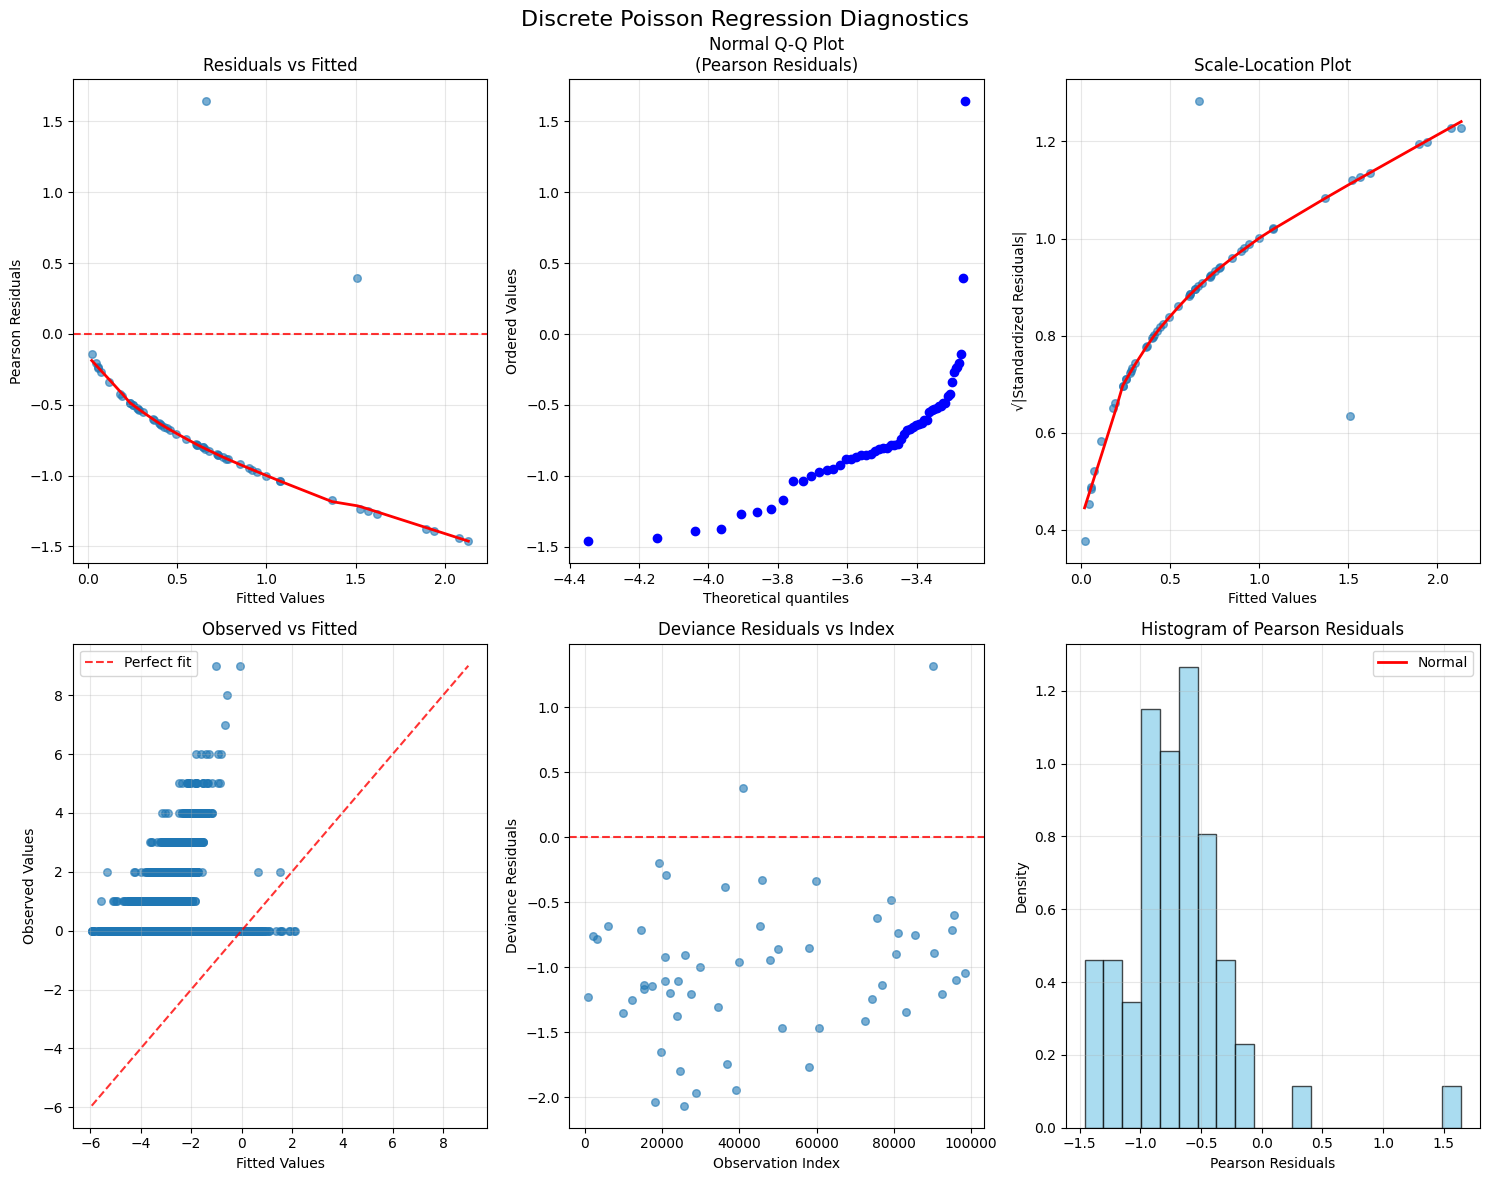

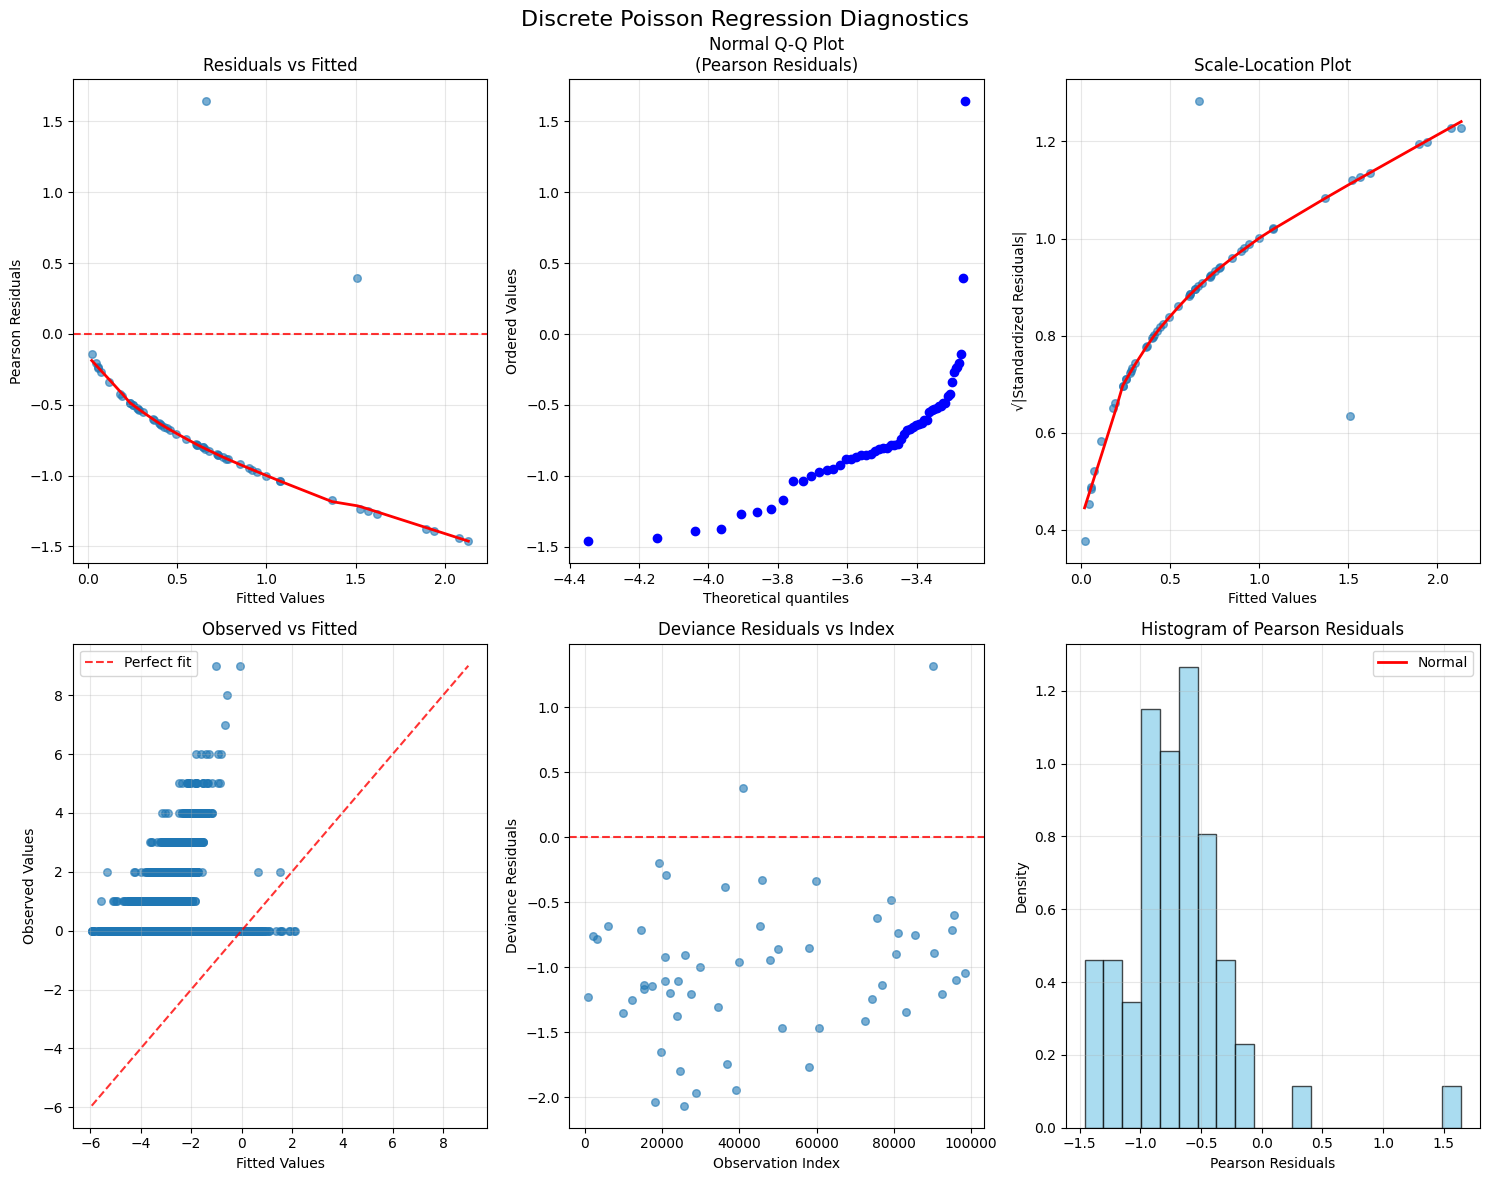

In [17]:
plot_discrete_poisson_diagnostics(general_model)

In [18]:

discrete_poisson_summary(general_model)

=== DISCRETE POISSON REGRESSION DIAGNOSTICS ===

Model: GeneralizedPoisson
Number of observations: 100277
Number of parameters: 9
Log-likelihood: -25610.8427
AIC: 51237.6854
BIC: 51313.8110

--- Residual Statistics ---
Response residuals - Mean: 3.3439, Std: 0.5285
Pearson residuals - Mean: nan, Std: nan

--- Dispersion ---
Pearson chi-squared: nan
Degrees of freedom: 100268
Dispersion parameter: nan
Dispersion appears reasonable for Poisson model

--- Model Fit ---
Mean observed: 0.0699
Mean fitted: -3.2740
Variance observed: 0.1210
Variance fitted: 0.2455

--- Zero Inflation Check ---
Number of zeros: 95266
Proportion of zeros: 0.9500
Expected zeros (Poisson): 2960001.5
Expected zero proportion: 29.5182


In [15]:
check_discrete_assumptions(general_model)


=== DISCRETE POISSON ASSUMPTION CHECKS ===

Shapiro-Wilk normality test (Pearson residuals):
Statistic: nan, p-value: nan
Jarque-Bera normality test (Pearson residuals):
Statistic: nan, p-value: nan

--- Residual Pattern Analysis ---
Min Pearson residual: nan
Max Pearson residual: nan
Range: nan
Observations with |Pearson residual| > 2: 0
